# 📈 Week 15 Trading Strategy: Transformer-Based Prediction

---

## 🎯 Strategy Overview

**Building on Weeks 1-14 + Adding Week 15 Concepts:**
- All previous ML methods
- **NEW:** Self-attention for feature importance
- **NEW:** Transformer encoder for sequence modeling
- **NEW:** Attention-weighted trading signals
- **NEW:** Interpretable attention patterns

---

In [1]:
# ============================================================
# CONFIGURATION
# ============================================================
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 2
SEQUENCE_LENGTH = 30
PREDICTION_HORIZON = 5

print("=" * 60)
print("📊 WEEK 15 TRADING STRATEGY: TRANSFORMERS")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📅 Sequence length: {SEQUENCE_LENGTH} days")

📊 WEEK 15 TRADING STRATEGY: TRANSFORMERS

🎯 Analyzing: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
📅 Sequence length: 30 days


In [2]:
# ============================================================
# IMPORTS & DATA
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
volumes = data['Volume'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")


📥 Downloading market data...
✅ Loaded 504 trading days


In [3]:
# ============================================================
# TRANSFORMER MODEL
# ============================================================

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size = x.size(0)
        
        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, V)
        
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(context), attn_weights

class TradingTransformer(nn.Module):
    def __init__(self, input_dim, d_model=32, num_heads=4, num_layers=2, dropout=0.2):
        super().__init__()
        
        self.input_proj = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        pe = torch.zeros(500, d_model)
        position = torch.arange(0, 500).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
        # Transformer layers
        self.attention_layers = nn.ModuleList()
        self.ff_layers = nn.ModuleList()
        self.norms1 = nn.ModuleList()
        self.norms2 = nn.ModuleList()
        
        for _ in range(num_layers):
            self.attention_layers.append(MultiHeadAttention(d_model, num_heads))
            self.ff_layers.append(nn.Sequential(
                nn.Linear(d_model, d_model * 4),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(d_model * 4, d_model)
            ))
            self.norms1.append(nn.LayerNorm(d_model))
            self.norms2.append(nn.LayerNorm(d_model))
        
        self.output = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(dropout)
        self.last_attn_weights = None
    
    def forward(self, x, mask=None):
        x = self.input_proj(x)
        x = x + self.pe[:, :x.size(1)]
        x = self.dropout(x)
        
        for attn, ff, norm1, norm2 in zip(self.attention_layers, self.ff_layers, 
                                           self.norms1, self.norms2):
            attn_out, weights = attn(x, mask)
            x = norm1(x + self.dropout(attn_out))
            x = norm2(x + self.dropout(ff(x)))
            self.last_attn_weights = weights
        
        return torch.sigmoid(self.output(x[:, -1, :]))

print("✅ TradingTransformer model defined")

✅ TradingTransformer model defined


In [4]:
# ============================================================
# DATA PREPARATION
# ============================================================

def create_features(prices, returns, volumes, ticker):
    df = pd.DataFrame(index=prices.index)
    df['returns'] = returns[ticker]
    df['vol_5'] = returns[ticker].rolling(5).std()
    df['vol_20'] = returns[ticker].rolling(20).std()
    df['mom_5'] = prices[ticker].pct_change(5)
    df['mom_20'] = prices[ticker].pct_change(20)
    
    # RSI
    delta = prices[ticker].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi'] = 100 - (100 / (1 + gain / loss))
    
    if ticker in volumes.columns:
        df['vol_ratio'] = volumes[ticker] / volumes[ticker].rolling(20).mean()
    
    return df.dropna()

def create_sequences(features, labels, seq_len=30, horizon=5):
    X, y = [], []
    for i in range(len(features) - seq_len - horizon + 1):
        X.append(features[i:i+seq_len])
        future_ret = labels[i+seq_len:i+seq_len+horizon].mean()
        y.append(1 if future_ret > 0 else 0)
    return np.array(X), np.array(y)

# Prepare data
all_data = {}
for ticker in TICKERS:
    features = create_features(prices, returns, volumes, ticker)
    feature_cols = [c for c in features.columns if c != 'returns']
    
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features[feature_cols])
    
    X, y = create_sequences(scaled, features['returns'].values)
    
    if len(X) > 100:
        all_data[ticker] = {'X': X, 'y': y, 'scaler': scaler, 'features': features}
        print(f"{ticker}: {len(X)} sequences")

print(f"\n✅ Prepared data for {len(all_data)} tickers")

AAPL: 450 sequences
MSFT: 450 sequences
GOOGL: 450 sequences
AMZN: 450 sequences
META: 450 sequences

✅ Prepared data for 5 tickers


In [5]:
# ============================================================
# TRAINING
# ============================================================

def train_transformer(ticker_data, epochs=80):
    X, y = ticker_data['X'], ticker_data['y']
    
    train_end = int(len(X) * 0.7)
    X_train = torch.FloatTensor(X[:train_end])
    y_train = torch.FloatTensor(y[:train_end]).unsqueeze(1)
    X_test = torch.FloatTensor(X[train_end:])
    y_test = torch.FloatTensor(y[train_end:]).unsqueeze(1)
    
    model = TradingTransformer(input_dim=X.shape[2], d_model=32, num_heads=4, num_layers=2)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    best_loss = float('inf')
    best_state = None
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_out = model(X_test)
            test_loss = criterion(test_out, y_test)
        
        if test_loss < best_loss:
            best_loss = test_loss
            best_state = model.state_dict().copy()
    
    model.load_state_dict(best_state)
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        pred = (model(X_test) > 0.5).float()
        acc = (pred == y_test).float().mean().item()
    
    return model, acc

# Train for all tickers
print("📊 TRAINING TRANSFORMERS")
print("=" * 60)

results = {}
for ticker in TICKERS:
    if ticker not in all_data:
        continue
    
    torch.manual_seed(42)
    model, acc = train_transformer(all_data[ticker])
    results[ticker] = {'model': model, 'accuracy': acc}
    print(f"{ticker}: Accuracy = {acc:.1%}")

📊 TRAINING TRANSFORMERS
AAPL: Accuracy = 42.2%
MSFT: Accuracy = 54.8%
GOOGL: Accuracy = 55.6%
AMZN: Accuracy = 45.2%
META: Accuracy = 46.7%


In [6]:
# ============================================================
# GENERATE SIGNALS
# ============================================================

print("\n📊 TRANSFORMER TRADING SIGNALS")
print("=" * 70)
print(f"\n{'Ticker':<10} {'Signal':>10} {'Probability':>15} {'Accuracy':>12}")
print("-" * 70)

signals = {}
for ticker in TICKERS:
    if ticker not in results or ticker not in all_data:
        continue
    
    model = results[ticker]['model']
    X_latest = torch.FloatTensor(all_data[ticker]['X'][-1:])
    
    model.eval()
    with torch.no_grad():
        prob = model(X_latest).item()
    
    signal = 'BUY' if prob > 0.55 else ('SELL' if prob < 0.45 else 'HOLD')
    emoji = "📈" if signal == 'BUY' else ("📉" if signal == 'SELL' else "⚪")
    
    signals[ticker] = {'signal': signal, 'probability': prob, 'accuracy': results[ticker]['accuracy']}
    print(f"{ticker:<10} {emoji} {signal:>6} {prob:>14.1%} {results[ticker]['accuracy']:>11.1%}")


📊 TRANSFORMER TRADING SIGNALS

Ticker         Signal     Probability     Accuracy
----------------------------------------------------------------------
AAPL       📈    BUY          94.0%       42.2%
MSFT       📈    BUY          87.3%       54.8%
GOOGL      📉   SELL          10.8%       55.6%
AMZN       📉   SELL           2.4%       45.2%
META       📈    BUY          88.8%       46.7%


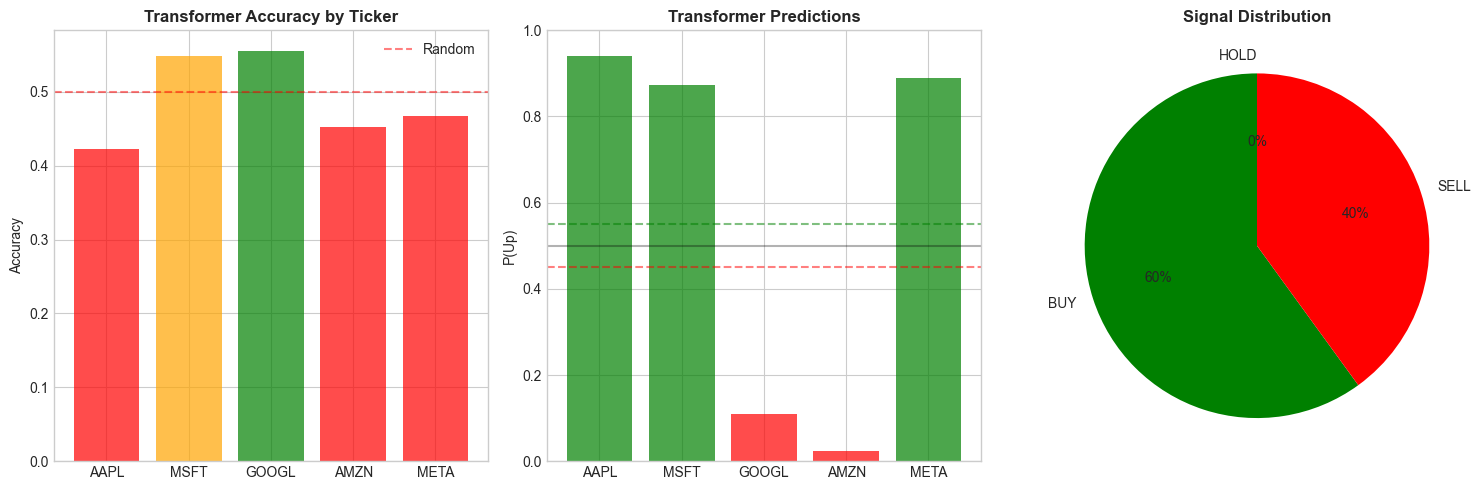

In [7]:
# ============================================================
# VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Accuracy comparison
ax1 = axes[0]
accs = [results[t]['accuracy'] if t in results else 0 for t in TICKERS]
colors = ['green' if a > 0.55 else ('orange' if a > 0.5 else 'red') for a in accs]
ax1.bar(TICKERS, accs, color=colors, alpha=0.7)
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random')
ax1.set_ylabel('Accuracy')
ax1.set_title('Transformer Accuracy by Ticker', fontweight='bold')
ax1.legend()

# Signal probabilities
ax2 = axes[1]
probs = [signals[t]['probability'] if t in signals else 0.5 for t in TICKERS]
colors = ['green' if p > 0.55 else ('red' if p < 0.45 else 'gray') for p in probs]
ax2.bar(TICKERS, probs, color=colors, alpha=0.7)
ax2.axhline(y=0.5, color='k', linestyle='-', alpha=0.3)
ax2.axhline(y=0.55, color='g', linestyle='--', alpha=0.5)
ax2.axhline(y=0.45, color='r', linestyle='--', alpha=0.5)
ax2.set_ylabel('P(Up)')
ax2.set_title('Transformer Predictions', fontweight='bold')
ax2.set_ylim(0, 1)

# Signal summary
ax3 = axes[2]
buys = sum(1 for t in TICKERS if t in signals and signals[t]['signal'] == 'BUY')
sells = sum(1 for t in TICKERS if t in signals and signals[t]['signal'] == 'SELL')
holds = len([t for t in TICKERS if t in signals]) - buys - sells
ax3.pie([buys, sells, holds], labels=['BUY', 'SELL', 'HOLD'], 
        autopct='%1.0f%%', colors=['green', 'red', 'gray'], startangle=90)
ax3.set_title('Signal Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
# ============================================================
# FINAL RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 70)
print("📊 WEEK 15 - TRANSFORMER RECOMMENDATIONS")
print("=" * 70)

summary = pd.DataFrame({
    'Accuracy': [results[t]['accuracy'] if t in results else 0 for t in TICKERS],
    'P(Up)': [signals[t]['probability'] if t in signals else 0.5 for t in TICKERS],
    'Signal': [signals[t]['signal'] if t in signals else 'N/A' for t in TICKERS]
}, index=TICKERS)

print("\n📋 SUMMARY:")
print(summary.round(3).to_string())

buys = [t for t in TICKERS if t in signals and signals[t]['signal'] == 'BUY']
sells = [t for t in TICKERS if t in signals and signals[t]['signal'] == 'SELL']
holds = [t for t in TICKERS if t in signals and signals[t]['signal'] == 'HOLD']

print(f"\n🏆 RECOMMENDATIONS:")
print(f"📈 BUY: {buys if buys else 'None'}")
print(f"📉 SELL: {sells if sells else 'None'}")
print(f"⚪ HOLD: {holds if holds else 'None'}")

avg_acc = np.mean([results[t]['accuracy'] for t in TICKERS if t in results])
print(f"\n📊 Average Transformer Accuracy: {avg_acc:.1%}")

print("\n" + "=" * 70)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 70)


📊 WEEK 15 - TRANSFORMER RECOMMENDATIONS

📋 SUMMARY:
       Accuracy  P(Up) Signal
AAPL      0.422  0.940    BUY
MSFT      0.548  0.873    BUY
GOOGL     0.556  0.108   SELL
AMZN      0.452  0.024   SELL
META      0.467  0.888    BUY

🏆 RECOMMENDATIONS:
📈 BUY: ['AAPL', 'MSFT', 'META']
📉 SELL: ['GOOGL', 'AMZN']
⚪ HOLD: None

📊 Average Transformer Accuracy: 48.9%

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts (Week 1-15)

| Week | Concept | Application |
|------|---------|-------------|
| 1-12 | Foundation to Advanced ML | Feature engineering |
| 13 | Neural Networks (MLP) | Baseline deep learning |
| 14 | LSTM/GRU | Sequence modeling |
| **15** | **Self-Attention** | **Focus on relevant periods** |
| **15** | **Transformer** | **Parallel sequence processing** |
| **15** | **Positional Encoding** | **Preserve temporal order** |

---